### imports, constants, functions

In [45]:
import tensorflow as tf
import numpy as np
import math, random
import matplotlib.pyplot as plt
from scipy import signal
from random import randrange
from numpy import random
import math   
import numpy as np 
import librosa
import matplotlib.pyplot as plt




In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise




In [46]:

#***convert complex np array to polar arrays (2 apprays; abs and angle)
def to_polar(complex_ar):
    return np.abs(complex_ar),np.angle(complex_ar)


In [13]:
def make_noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.zeros(Y.shape)
    if randrange(2) == 0 :
      noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    else:
      noise = np.random.normal(0,0.25,Y.shape)
    return Y + noise


In [14]:
def calc_power(x):
  s=np.square(x)
  average = sum(s) / len(s)
  return average

In [15]:
def calc_SNR(reference, signal):
    noise = signal-reference

    powS = calc_power(signal)
    powN = calc_power(noise)
    if powN !=0:
      return 10*math.log10(powS/powN)
    else:
      return "ERROR"


In [16]:
figSize = (15,3)
samplingConst =  100
timePoints = np.linspace(0, 1, 1000 * samplingConst)

###sawtooth

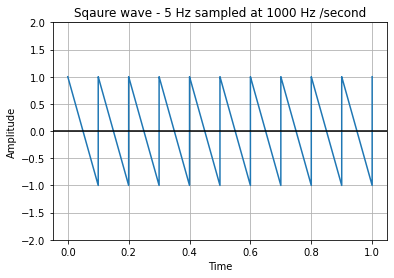

In [17]:
SAWTOOTH = signal.sawtooth(-2 * np.pi * 10 * timePoints  - 0.0004)
plt.plot(timePoints, SAWTOOTH )
plt.title('Sqaure wave - 5 Hz sampled at 1000 Hz /second')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.ylim(-2, 2)
plt.show()

### triangle

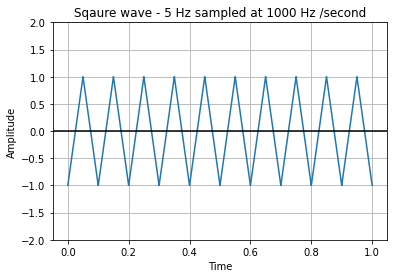

In [18]:
TRIANGLE = signal.sawtooth(2 * np.pi * 10 * timePoints, 0.5)
plt.plot(timePoints, TRIANGLE)
plt.title('Sqaure wave - 5 Hz sampled at 1000 Hz /second')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.ylim(-2, 2)
plt.show()

### sine

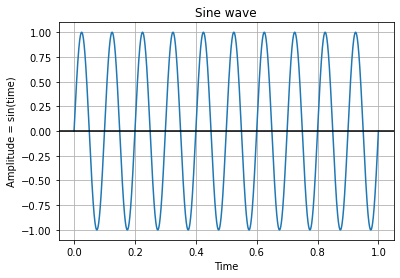

In [19]:
SINE   = np.sin(2 * np.pi *10* timePoints)
plt.plot(timePoints, SINE)
plt.title('Sine wave') 
plt.xlabel('Time')
plt.ylabel('Amplitude = sin(time)') 
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.show()
# Display the sine wave

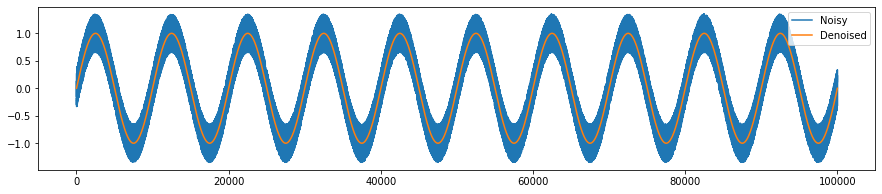

In [20]:
plt.figure(figsize = figSize)
plt.plot( make_noisy(SINE), label='Noisy')
plt.plot(SINE, label ='Denoised')
plt.legend()

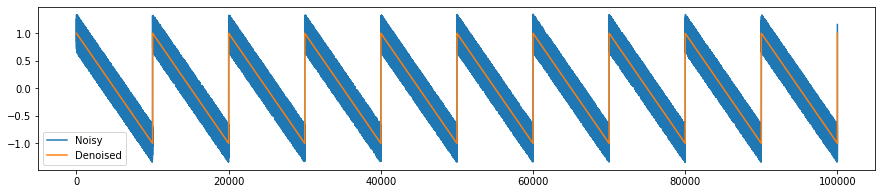

In [21]:
plt.figure(figsize =figSize)
plt.plot( make_noisy(SAWTOOTH), label='Noisy')
plt.plot(SAWTOOTH, label ='Denoised')
plt.legend()

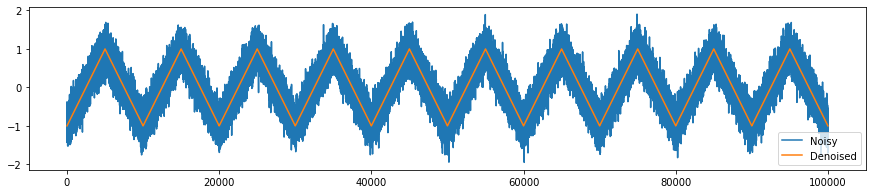

In [22]:
plt.figure(figsize = figSize)
plt.plot( make_noisy(TRIANGLE), label='Noisy')
plt.plot(TRIANGLE, label ='Denoised')
plt.legend()

### Sine wave noise removal using RNN and LSTM 

In [ ]:
denoised = SINE
noisy= make_noisy(SINE)
y_train , y_validation , y_test = denoised[ :700*samplingConst  ]   , denoised[ 700*samplingConst:800*samplingConst ]  , denoised[ 800*samplingConst: ] 
x_train , x_validation , x_test = noisy[ :700*samplingConst ]   , noisy[ 700*samplingConst:800*samplingConst  ]  , noisy[ 800*samplingConst: ]

In [ ]:
x_train = x_train.reshape((700,samplingConst,1))
x_validation = x_validation.reshape((100,samplingConst,1))
x_test = x_test.reshape((200,samplingConst,1))

y_train = y_train.reshape((700,samplingConst,1))
y_validation = y_validation.reshape((100,samplingConst,1))
y_test = y_test.reshape((200,samplingConst,1))

In [ ]:
# SimpleRNN
SimpleRNNmodel=tf.keras.models.Sequential()
SimpleRNNmodel.add(tf.keras.layers.SimpleRNN(30, input_shape = (samplingConst,1) ,  activation='tanh' ))
SimpleRNNmodel.add(tf.keras.layers.Dense(samplingConst, activation='tanh'))
SimpleRNNmodel.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
history1 = SimpleRNNmodel.fit(x_train, y_train, epochs=6, batch_size= 1, validation_data= (x_validation , y_validation),  verbose=1)

Epoch 1/6
700/700 [==============================] - 10s 14ms/step - loss: 0.0538 - val_loss: 0.0210
Epoch 2/6
700/700 [==============================] - 9s 13ms/step - loss: 0.0141 - val_loss: 0.0086
Epoch 3/6
700/700 [==============================] - 9s 13ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 4/6
700/700 [==============================] - 9s 13ms/step - loss: 0.0121 - val_loss: 0.0085
Epoch 5/6
700/700 [==============================] - 9s 13ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 6/6
700/700 [==============================] - 9s 13ms/step - loss: 0.0100 - val_loss: 0.0062


Text(0.5, 1.0, 'simple RNN, SINE, Loss History')

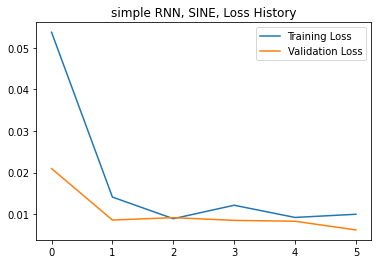

In [ ]:
fig = plt.figure()
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('simple RNN, SINE, Loss History')

In [ ]:
generated_output = SimpleRNNmodel.predict(x_test)
reshaped_generated_output = generated_output.reshape( (200*samplingConst,1))
noisyInput = x_test.reshape( (200*samplingConst,1))
desiredDenoisedOutput = y_test.reshape(200*samplingConst,1)

In [ ]:
SNR_BEFORE_SINE_RNN = calc_SNR( desiredDenoisedOutput , noisyInput )
SNR_AFTER_SINE_RNN = calc_SNR( desiredDenoisedOutput , reshaped_generated_output )

In [ ]:
SNR_BEFORE_SINE_RNN

9.581515671992268

In [ ]:
SNR_AFTER_SINE_RNN

18.49842130692618

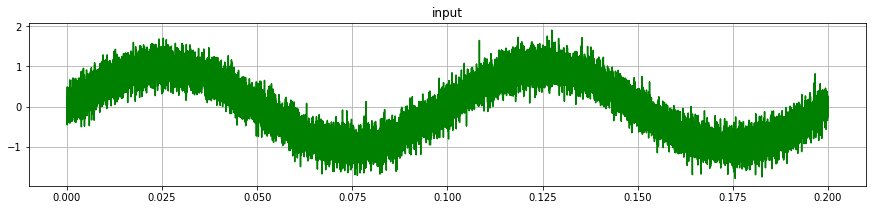

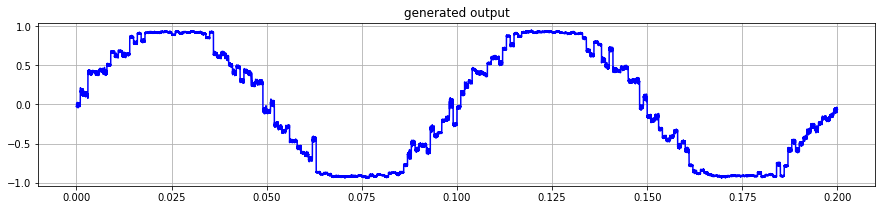

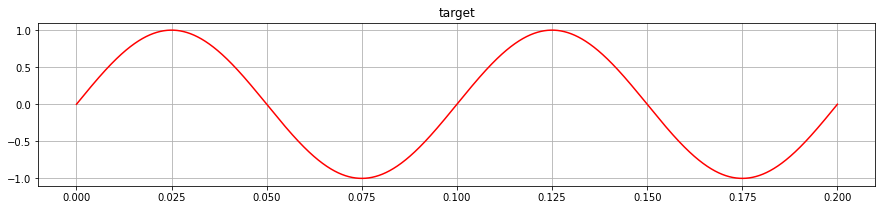

In [ ]:
plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , noisyInput , 'g' )
plt.title('input')
plt.grid()

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , reshaped_generated_output , 'b' )
plt.title('generated output')
plt.grid()

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , desiredDenoisedOutput , 'r')
plt.title('target')
plt.grid()


In [ ]:
# LSTM
model_LSTM=tf.keras.models.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(30, input_shape = (samplingConst,1) ,  activation='tanh' ))
model_LSTM.add(tf.keras.layers.Dense(samplingConst, activation='tanh'))
model_LSTM.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
history2 = model_LSTM.fit(x_train, y_train, epochs=30, batch_size= 1, validation_data= (x_validation , y_validation),  verbose=1)


Epoch 1/30
700/700 [==============================] - 20s 25ms/step - loss: 0.0443 - val_loss: 0.0024
Epoch 2/30
700/700 [==============================] - 17s 25ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/30
700/700 [==============================] - 17s 24ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/30
700/700 [==============================] - 17s 24ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 5/30
700/700 [==============================] - 17s 24ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 6/30
700/700 [==============================] - 18s 25ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/30
700/700 [==============================] - 17s 25ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 8/30
700/700 [==============================] - 17s 25ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/30
700/700 [==============================] - 19s 27ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/30
700/700 [==============================] - 17s 25ms/step - loss: 0.001

In [ ]:
fig = plt.figure()
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM, Loss History')

In [ ]:
generated_output = model_LSTM.predict(x_test)
reshaped_generated_output = generated_output.reshape( (200*samplingConst,1))
noisyInput = x_test.reshape( (200*samplingConst,1))
desiredDenoisedOutput = y_test.reshape(200*samplingConst,1)

In [ ]:
SNR_BEFORE_SINE_RNN = calc_SNR( desiredDenoisedOutput , noisyInput )
SNR_AFTER_SINE_RNN = calc_SNR( desiredDenoisedOutput , reshaped_generated_output )

Text(0.5, 1.0, 'generated output')

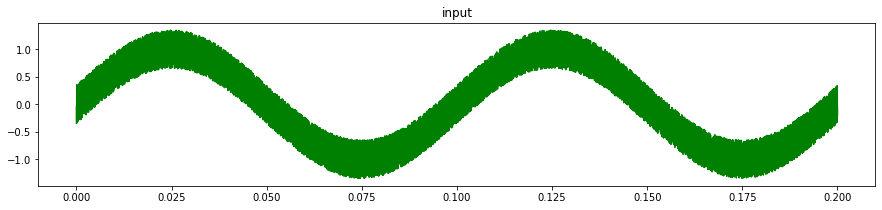

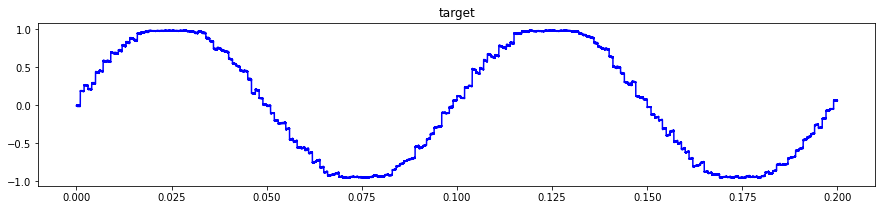

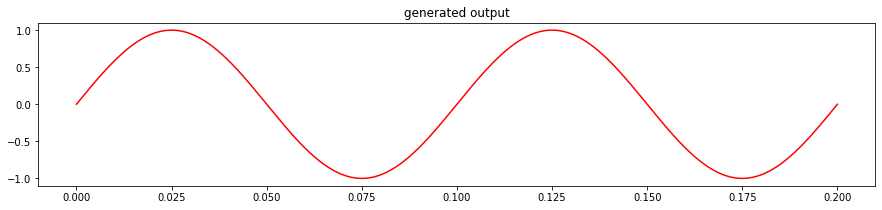

In [ ]:
plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , noisyInput , 'g' )
plt.title('input')

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , reshaped_generated_output , 'b' )
plt.title('generated output')

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , desiredDenoisedOutput , 'r')
plt.title('target')

### SAWTOOTH wave noise removal using SIMPLE RNN and LSTM

In [ ]:
denoised = SAWTOOTH
noisy= make_noisy(SAWTOOTH)
y_train , y_validation , y_test = denoised[ :700*samplingConst  ]   , denoised[ 700*samplingConst:800*samplingConst ]  , denoised[ 800*samplingConst: ] 
x_train , x_validation , x_test = noisy[ :700*samplingConst ]   , noisy[ 700*samplingConst:800*samplingConst  ]  , noisy[ 800*samplingConst: ]

In [ ]:
x_train = x_train.reshape((700,samplingConst,1))
x_validation = x_validation.reshape((100,samplingConst,1))
x_test = x_test.reshape((200,samplingConst,1))

y_train = y_train.reshape((700,samplingConst,1))
y_validation = y_validation.reshape((100,samplingConst,1))
y_test = y_test.reshape((200,samplingConst,1))

In [ ]:
# SimpleRNN
SimpleRNNmodel=tf.keras.models.Sequential()
SimpleRNNmodel.add(tf.keras.layers.SimpleRNN(30, input_shape = (samplingConst,1) ,  activation='tanh' ))
SimpleRNNmodel.add(tf.keras.layers.Dense(samplingConst, activation='tanh'))
SimpleRNNmodel.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
history3 = SimpleRNNmodel.fit(x_train, y_train, epochs=6, batch_size= 1, validation_data= (x_validation , y_validation),  verbose=1)


Epoch 1/10
700/700 [==============================] - 10s 13ms/step - loss: 0.0522
Epoch 2/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0145
Epoch 3/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0105
Epoch 4/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0083
Epoch 5/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0061
Epoch 6/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0056
Epoch 7/10
700/700 [==============================] - 9s 12ms/step - loss: 0.0066
Epoch 8/10
700/700 [==============================] - 9s 13ms/step - loss: 0.0052
Epoch 9/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0049
Epoch 10/10
700/700 [==============================] - 9s 12ms/step - loss: 0.0050


In [ ]:
fig = plt.figure()
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('simple RNN, SAWTOOTH Loss History')

In [ ]:
generated_output = SimpleRNNmodel.predict(x_test)
reshaped_generated_output = generated_output.reshape( (200*samplingConst,1))
noisyInput = x_test.reshape( (200*samplingConst,1))
desiredDenoisedOutput = y_test.reshape(200*samplingConst,1)

In [ ]:
SNR_BEFORE_SINE_RNN = calc_SNR( desiredDenoisedOutput , noisyInput )
SNR_AFTER_SINE_RNN = calc_SNR( desiredDenoisedOutput , reshaped_generated_output )

Text(0.5, 1.0, 'generated output')

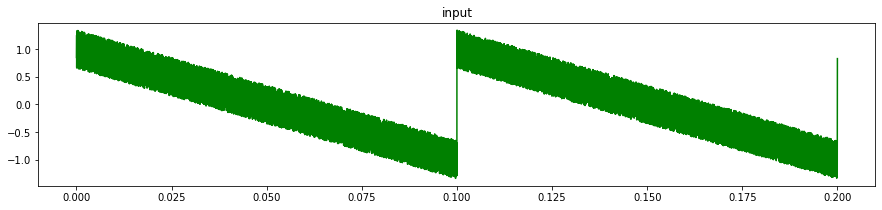

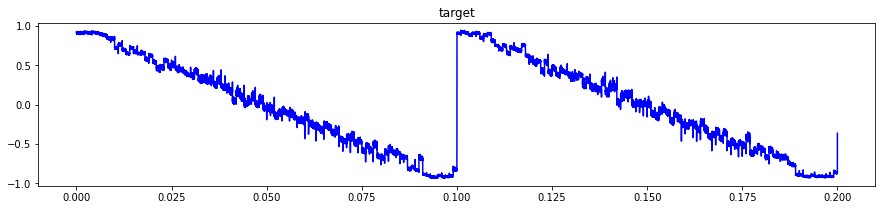

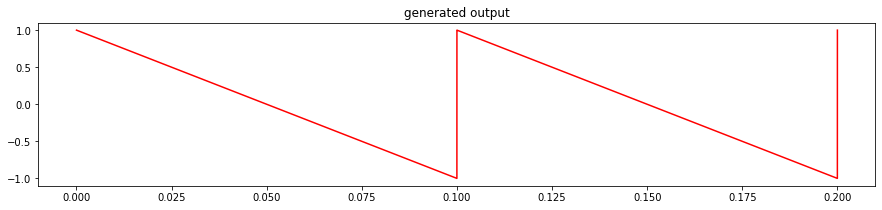

In [ ]:
plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , noisyInput , 'g' )
plt.title('input')

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , reshaped_generated_output , 'b' )
plt.title('generated output')

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , desiredDenoisedOutput , 'r')
plt.title('target')


In [ ]:
# LSTM
model_LSTM=tf.keras.models.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(30, input_shape = (samplingConst,1) ,  activation='tanh' ))
model_LSTM.add(tf.keras.layers.Dense(samplingConst, activation='tanh'))
model_LSTM.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
history4 = model_LSTM.fit(x_train, y_train, epochs=10, batch_size= 1, validation_data= (x_validation , y_validation),  verbose=1)


Epoch 1/10
700/700 [==============================] - 18s 23ms/step - loss: 0.0321
Epoch 2/10
700/700 [==============================] - 16s 23ms/step - loss: 0.0043
Epoch 3/10
700/700 [==============================] - 16s 23ms/step - loss: 0.0037
Epoch 4/10
700/700 [==============================] - 16s 23ms/step - loss: 0.0036
Epoch 5/10
700/700 [==============================] - 16s 23ms/step - loss: 0.0035
Epoch 6/10
700/700 [==============================] - 16s 23ms/step - loss: 0.0034
Epoch 7/10
700/700 [==============================] - 16s 23ms/step - loss: 0.0032
Epoch 8/10
700/700 [==============================] - 16s 23ms/step - loss: 0.0028
Epoch 9/10
700/700 [==============================] - 17s 24ms/step - loss: 0.0028
Epoch 10/10
700/700 [==============================] - 17s 25ms/step - loss: 0.0032


In [ ]:
fig = plt.figure()
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM, Loss History')

In [ ]:
generated_output = model_LSTM.predict(x_test)
reshaped_generated_output = generated_output.reshape( (200*samplingConst,1))
noisyInput = x_test.reshape( (200*samplingConst,1))
desiredDenoisedOutput = y_test.reshape(200*samplingConst,1)

In [ ]:
SNR_BEFORE_SINE_RNN = calc_SNR( desiredDenoisedOutput , noisyInput )
SNR_AFTER_SINE_RNN = calc_SNR( desiredDenoisedOutput , reshaped_generated_output )

Text(0.5, 1.0, 'generated output')

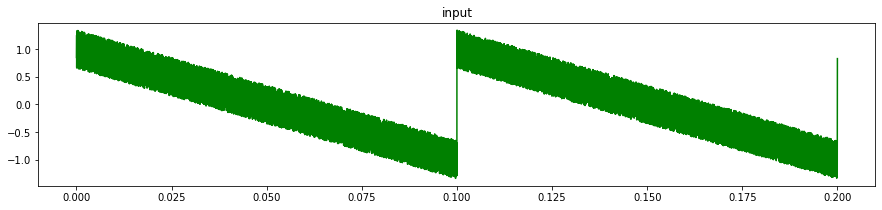

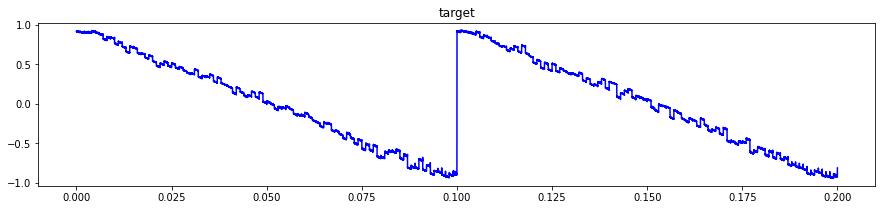

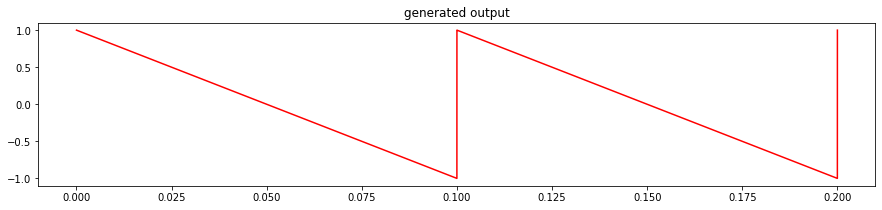

In [ ]:
plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , noisyInput , 'g' )
plt.title('input')

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , reshaped_generated_output , 'b' )
plt.title('generated output')

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , desiredDenoisedOutput , 'r')
plt.title('target')


###TRIANGLE wave noise removal using simple RNN and LSTM

In [ ]:
denoised = TRIANGLE
noisy= make_noisy(TRIANGLE)
y_train , y_validation , y_test = denoised[ :700*samplingConst  ]   , denoised[ 700*samplingConst:800*samplingConst ]  , denoised[ 800*samplingConst: ] 
x_train , x_validation , x_test = noisy[ :700*samplingConst ]   , noisy[ 700*samplingConst:800*samplingConst  ]  , noisy[ 800*samplingConst: ]

In [ ]:
x_train = x_train.reshape((700,samplingConst,1))
x_validation = x_validation.reshape((100,samplingConst,1))
x_test = x_test.reshape((200,samplingConst,1))

y_train = y_train.reshape((700,samplingConst,1))
y_validation = y_validation.reshape((100,samplingConst,1))
y_test = y_test.reshape((200,samplingConst,1))

In [ ]:
# SimpleRNN
SimpleRNNmodel=tf.keras.models.Sequential()
SimpleRNNmodel.add(tf.keras.layers.SimpleRNN(30, input_shape = (samplingConst,1) ,  activation='tanh' ))
SimpleRNNmodel.add(tf.keras.layers.Dense(samplingConst, activation='tanh'))
SimpleRNNmodel.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
history5 = SimpleRNNmodel.fit(x_train, y_train, epochs=10, batch_size= 1, validation_data= (x_validation , y_validation),  verbose=1)


Epoch 1/10
700/700 [==============================] - 9s 12ms/step - loss: 0.0395
Epoch 2/10
700/700 [==============================] - 9s 12ms/step - loss: 0.0125
Epoch 3/10
700/700 [==============================] - 8s 11ms/step - loss: 0.0116
Epoch 4/10
700/700 [==============================] - 8s 11ms/step - loss: 0.0121
Epoch 5/10
700/700 [==============================] - 9s 12ms/step - loss: 0.0100
Epoch 6/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0087
Epoch 7/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0082
Epoch 8/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0081
Epoch 9/10
700/700 [==============================] - 9s 12ms/step - loss: 0.0071
Epoch 10/10
700/700 [==============================] - 8s 12ms/step - loss: 0.0064


In [ ]:
fig = plt.figure()
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('simple RNN, SAWTOOTH Loss History')

In [ ]:
generated_output = SimpleRNNmodel.predict(x_test)
reshaped_generated_output = generated_output.reshape( (200*samplingConst,1))
noisyInput = x_test.reshape( (200*samplingConst,1))
desiredDenoisedOutput = y_test.reshape(200*samplingConst,1)

In [ ]:
SNR_BEFORE_SINE_RNN = calc_SNR( desiredDenoisedOutput , noisyInput )
SNR_AFTER_SINE_RNN = calc_SNR( desiredDenoisedOutput , reshaped_generated_output )

Text(0.5, 1.0, 'generated output')

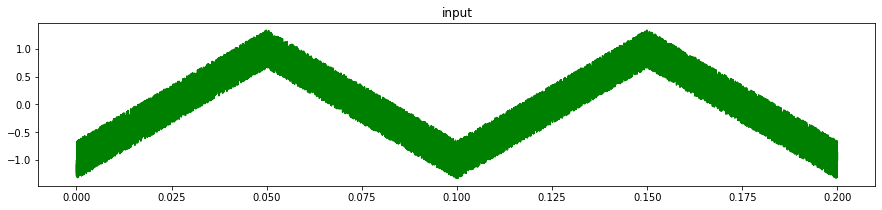

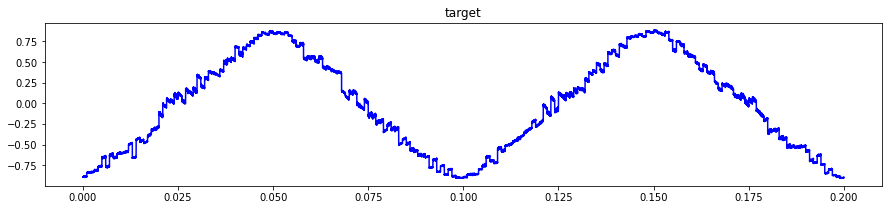

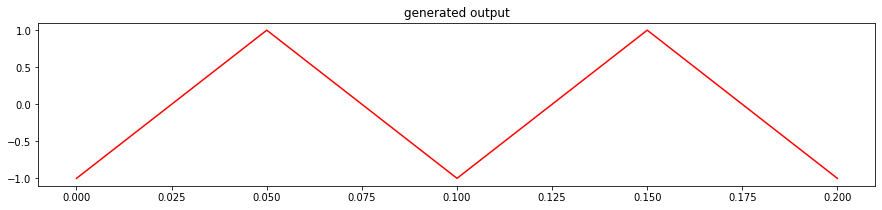

In [ ]:
plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , noisyInput , 'g' )
plt.title('input')
plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , reshaped_generated_output , 'b' )
plt.title('generated output')

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , desiredDenoisedOutput , 'r')
plt.title('target')


In [ ]:
# LSTM
model_LSTM=tf.keras.models.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(30, input_shape = (samplingConst,1) ,  activation='tanh' ))
model_LSTM.add(tf.keras.layers.Dense(samplingConst, activation='tanh'))
model_LSTM.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
history6 = model_LSTM.fit(x_train, y_train, epochs=10, batch_size= 1, validation_data= (x_validation , y_validation),  verbose=1)


Epoch 1/10
700/700 [==============================] - 17s 22ms/step - loss: 0.0303
Epoch 2/10
700/700 [==============================] - 16s 22ms/step - loss: 0.0048
Epoch 3/10
700/700 [==============================] - 16s 22ms/step - loss: 0.0047
Epoch 4/10
700/700 [==============================] - 15s 21ms/step - loss: 0.0039
Epoch 5/10
700/700 [==============================] - 16s 23ms/step - loss: 0.0039
Epoch 6/10
700/700 [==============================] - 15s 22ms/step - loss: 0.0039
Epoch 7/10
700/700 [==============================] - 15s 22ms/step - loss: 0.0035
Epoch 8/10
700/700 [==============================] - 16s 22ms/step - loss: 0.0036
Epoch 9/10
700/700 [==============================] - 16s 22ms/step - loss: 0.0033
Epoch 10/10
700/700 [==============================] - 15s 21ms/step - loss: 0.0036


In [ ]:
fig = plt.figure()
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM, Loss History')

In [ ]:
generated_output = model_LSTM.predict(x_test)
reshaped_generated_output = generated_output.reshape( (200*samplingConst,1))
noisyInput = x_test.reshape( (200*samplingConst,1))
desiredDenoisedOutput = y_test.reshape(200*samplingConst,1)

In [ ]:
SNR_BEFORE_SINE_RNN = calc_SNR( desiredDenoisedOutput , noisyInput )
SNR_AFTER_SINE_RNN = calc_SNR( desiredDenoisedOutput , reshaped_generated_output )

Text(0.5, 1.0, 'generated output')

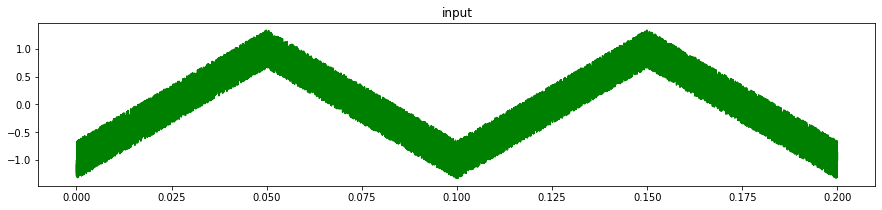

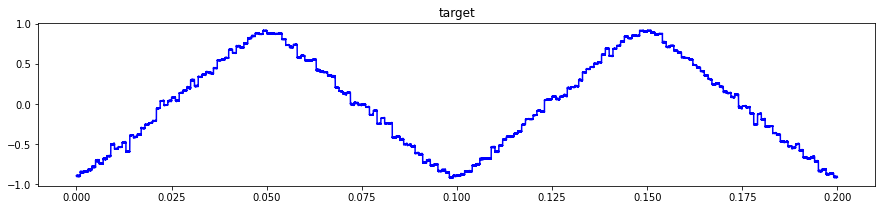

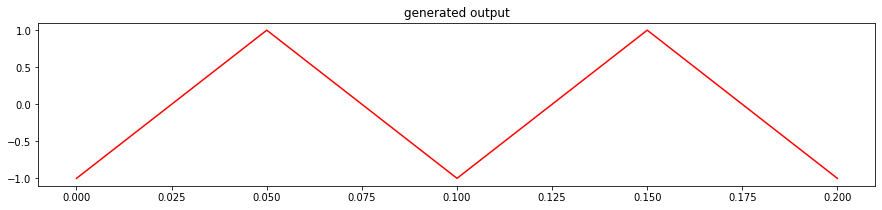

In [ ]:
plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , noisyInput , 'g' )
plt.title('input')

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , reshaped_generated_output , 'b' )
plt.title('generated output')

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , desiredDenoisedOutput , 'r')
plt.title('target')

### unstationary noise

In [ ]:
np.pi


3.141592653589793

###2D

In [ ]:
def create_noise(sig):
  return sig +  np.random.normal(0,0.05,sig.shape)

In [ ]:
figureSize = (12, 5)
t = np.linspace(0, 20*np.pi, 1000 )
samplingConst = 100

a circle with R=1

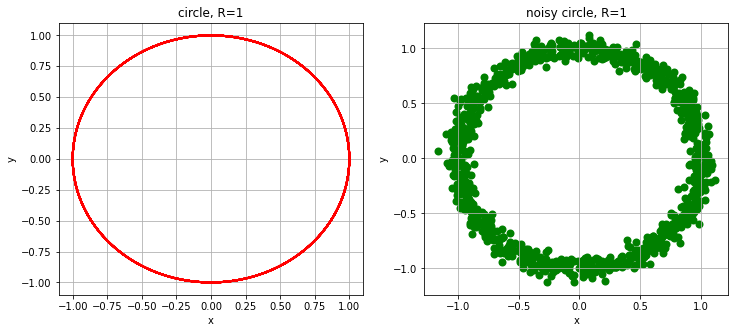

In [ ]:
x_circle = np.cos(t)
y_circle = np.sin(t)
# x_circle_noisy , y_circle_noisy = make_noisy(x_circle) , make_noisy(y_circle)
x_circle_noisy , y_circle_noisy = create_noise(x_circle) , create_noise(y_circle)

# plt.figure()
plt.figure(figsize = figureSize)

plt.subplot(1,2,1)
plt.plot(x_circle,y_circle,linewidth=2,color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('circle, R=1')
plt.grid()



# plt.figure(figsize = figureSize)
plt.subplot(1,2,2)
plt.scatter(x_circle_noisy,y_circle_noisy,linewidth=2,color='g'  )
plt.xlabel('x')
plt.ylabel('y')
plt.title('noisy circle, R=1')
plt.grid()

In [ ]:
noisy = np.zeros( (100, 1000  , 2))
denoised = np.zeros ( (100 , 1000  , 2))

for i in range(100):
  noisy[i,: ,0] , noisy[i , : , 1] = create_noise(x_circle) , create_noise(y_circle)
  denoised[i,: ,0] , denoised[i , : , 1] = x_circle ,y_circle


In [ ]:
samplingConst =1
y_train , y_validation , y_test = denoised[ :,  :700*samplingConst  ], denoised[ : ,  700*samplingConst:800*samplingConst ], denoised[:,  800*samplingConst: ] 
x_train , x_validation , x_test = noisy[ :,:700*samplingConst ]   , noisy[:, 700*samplingConst:800*samplingConst  ]  , noisy[ :, 800*samplingConst: ]

In [ ]:
y_train.shape , y_validation.shape , y_test.shape , x_train.shape , x_validation.shape , x_test.shape

((100, 700, 2),
 (100, 100, 2),
 (100, 200, 2),
 (100, 700, 2),
 (100, 100, 2),
 (100, 200, 2))

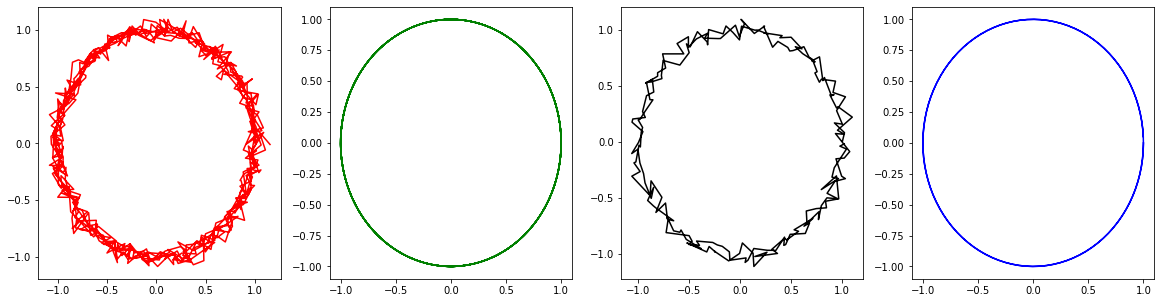

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,4,1)
plt.plot(x_train[1, : , 0], x_train[1,: , 1], color= 'r')
plt.subplot(1,4,2)
plt.plot(y_train[1, : , 0] , y_train[1, : , 1],color ='g')
plt.subplot(1,4,3)
plt.plot(x_test[1, : , 0], x_test[1, : , 1] , color= 'k')
plt.subplot(1,4,4)
plt.plot(y_test[1, : , 0], y_test[1, : , 1] , color= 'b')

In [ ]:
x_train = x_train.reshape((700,100,2))
x_validation = x_validation.reshape((100,100,2))
x_test = x_test.reshape((200,100,2))

y_train = y_train.reshape((700,100,2))
y_validation = y_validation.reshape((100,100,2))
y_test = y_test.reshape((200,100,2))

In [ ]:
y_train.shape , y_validation.shape , y_test.shape , x_train.shape , x_validation.shape , x_test.shape

((700, 100, 2),
 (100, 100, 2),
 (200, 100, 2),
 (700, 100, 2),
 (100, 100, 2),
 (200, 100, 2))

In [ ]:
model_input = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
model_output= tf.keras.layers.SimpleRNN(2, return_sequences=True)(model_input)
# model_output = tf.keras.layers.Dense(2 , activation = 'tanh') (m)
RNNmodel = tf.keras.models.Model(inputs=model_input, outputs=model_output)
RNNmodel.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
# my_adam_optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(loss='mse', optimizer= my_adam_optimizer )
history=RNNmodel.fit(x_train, y_train, epochs=10, validation_data=(x_validation, y_validation), batch_size=1, verbose=1)

Epoch 1/10
700/700 [==============================] - 9s 11ms/step - loss: 0.1184 - val_loss: 0.0359
Epoch 2/10
700/700 [==============================] - 7s 10ms/step - loss: 0.0223 - val_loss: 0.0161
Epoch 3/10
700/700 [==============================] - 9s 13ms/step - loss: 0.0148 - val_loss: 0.0133
Epoch 4/10
700/700 [==============================] - 7s 10ms/step - loss: 0.0124 - val_loss: 0.0113
Epoch 5/10
700/700 [==============================] - 10s 15ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 6/10
700/700 [==============================] - 7s 11ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 7/10
700/700 [==============================] - 7s 10ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 8/10
700/700 [==============================] - 9s 13ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 9/10
700/700 [==============================] - 7s 10ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 10/10
700/700 [==============================] - 8s 11ms/step - loss: 0.0059 - val_l

In [ ]:
# Evaluation on the training
print('Evaluation with Test Set:')
loss = RNNmodel.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
# Prediction
y_hat = RNNmodel.predict(x_test)

Evaluation with Test Set:
7/7 [==============================] - 0s 11ms/step - loss: 0.0056
Test loss: 0.00560616422444582


In [ ]:
y_resh = y_test.reshape((200,100,2))
x_resh = x_test.reshape((100,200,2))
resh = y_hat.reshape((100,200 , 2))

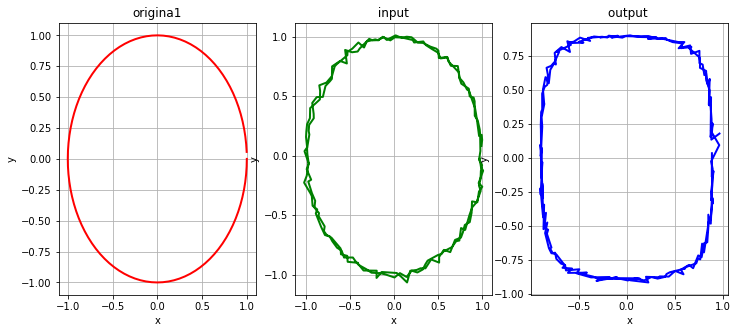

In [ ]:
plt.figure(figsize = figureSize)
plt.subplot(1,3,1)

# plt.scatter(y_test.reshape((20000,2))[:,0],y_test.reshape((20000,2))[:,1],linewidth=2,color='r')
plt.plot(y_resh [1, : , 0],y_resh[1 , :, 1],linewidth=2,color='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('origina1')
plt.grid()

plt.subplot(1,3,2)
# plt.scatter(x_test.reshape((20000,2))[:,0],y_hat.reshape((20000,2))[:,1],linewidth=2,color='g')
plt.plot(x_resh [1, : , 0], x_resh[1 , :, 1],linewidth=2,color='g')

plt.xlabel('x')
plt.ylabel('y')
plt.title(' input ')
plt.grid()


plt.subplot(1,3,3)
plt.plot(resh [1, : , 0], resh[1 , :, 1],linewidth=2,color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('output ')
plt.grid()

epitrochoid

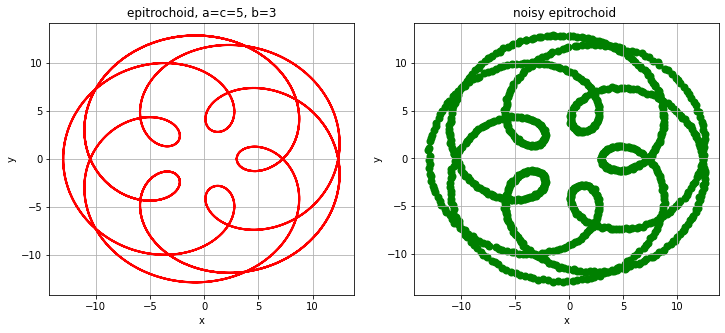

In [ ]:
a=5;b=3;c=5
x_epitrochoid = (a+b)*np.cos(t)-c*np.cos((a/b +1)* t)
y_epitrochoid = (a+b)*np.sin(t)-c*np.sin((a/b +1)* t)
x_epitrochoid_noisy , y_epitrochoid_noisy = create_noise(x_epitrochoid) , create_noise(y_epitrochoid)
plt.figure(figsize = figureSize)

plt.subplot(1,2,1)

plt.plot(x_epitrochoid,y_epitrochoid,linewidth=2,color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('epitrochoid, a=c=5, b=3')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(x_epitrochoid_noisy,y_epitrochoid_noisy,linewidth=2,color='g'  )
plt.xlabel('x')
plt.ylabel('y')
plt.title('noisy epitrochoid ')
plt.grid()

In [ ]:
noisy = np.zeros( (100, 1000  , 2))
denoised = np.zeros ( (100 , 1000  , 2))

for i in range(100):
  noisy[i,: ,0] , noisy[i , : , 1] = create_noise(x_epitrochoid) , create_noise(y_epitrochoid)
  denoised[i,: ,0] , denoised[i , : , 1] = x_epitrochoid ,y_epitrochoid


In [ ]:
maximum = noisy.max()
noisy = noisy / maximum
denoised = denoised / maximum

In [ ]:
samplingConst =1
y_train , y_validation , y_test = denoised[ :,  :700*samplingConst  ], denoised[ : ,  700*samplingConst:800*samplingConst ], denoised[:,  800*samplingConst: ] 
x_train , x_validation , x_test = noisy[ :,:700*samplingConst ]   , noisy[:, 700*samplingConst:800*samplingConst  ]  , noisy[ :, 800*samplingConst: ]

In [ ]:
y_train.shape , y_validation.shape , y_test.shape , x_train.shape , x_validation.shape , x_test.shape

((100, 700, 2),
 (100, 100, 2),
 (100, 200, 2),
 (100, 700, 2),
 (100, 100, 2),
 (100, 200, 2))

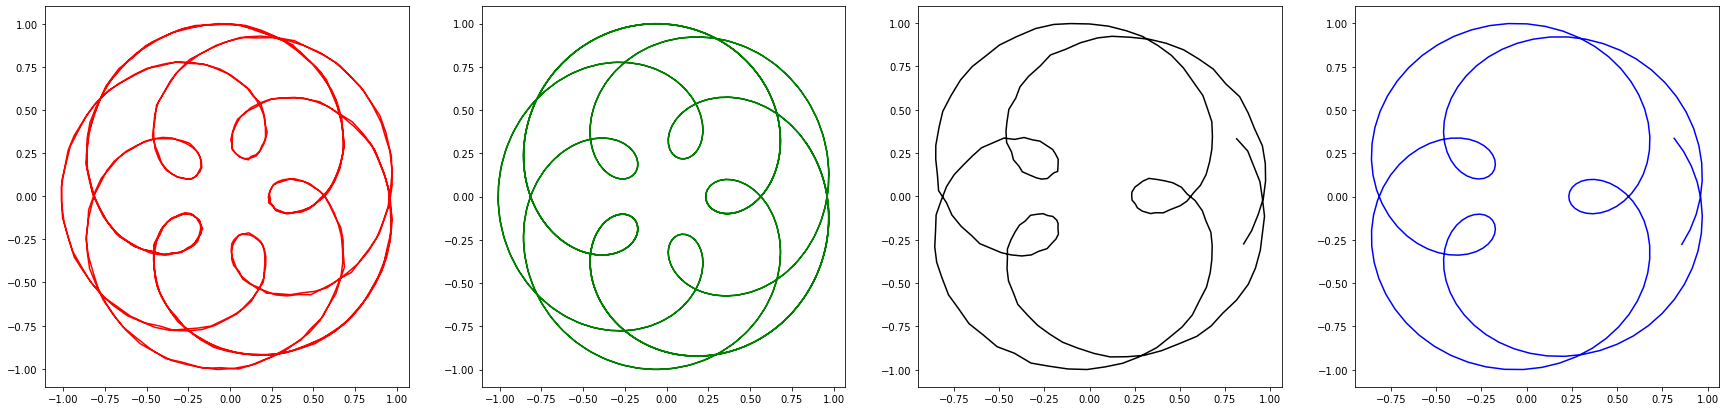

In [ ]:
plt.figure(figsize = (30,7))
plt.subplot(1,4,1)
plt.plot(x_train[1, : , 0], x_train[1,: , 1], color= 'r')
plt.subplot(1,4,2)
plt.plot(y_train[1, : , 0] , y_train[1, : , 1],color ='g')
plt.subplot(1,4,3)
plt.plot(x_test[1, : , 0], x_test[1, : , 1] , color= 'k')
plt.subplot(1,4,4)
plt.plot(y_test[1, : , 0], y_test[1, : , 1] , color= 'b')

In [ ]:
y_train.shape , y_validation.shape , y_test.shape , x_train.shape , x_validation.shape , x_test.shape

((100, 700, 2),
 (100, 100, 2),
 (100, 200, 2),
 (100, 700, 2),
 (100, 100, 2),
 (100, 200, 2))

In [ ]:
x_train = x_train.reshape((700,100,2))
x_validation = x_validation.reshape((100,100,2))
x_test = x_test.reshape((200,100,2))

y_train = y_train.reshape((700,100,2))
y_validation = y_validation.reshape((100,100,2))
y_test = y_test.reshape((200,100,2))

In [ ]:
y_train.shape , y_validation.shape , y_test.shape , x_train.shape , x_validation.shape , x_test.shape

((700, 100, 2),
 (100, 100, 2),
 (200, 100, 2),
 (700, 100, 2),
 (100, 100, 2),
 (200, 100, 2))

In [ ]:
model_input = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
model_output= tf.keras.layers.SimpleRNN(2, return_sequences=True)(model_input)
# model_output = tf.keras.layers.Dense(2 , activation = 'tanh') (m)
RNNmodel = tf.keras.models.Model(inputs=model_input, outputs=model_output)
RNNmodel.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
# my_adam_optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(loss='mse', optimizer= my_adam_optimizer )
history=RNNmodel.fit(x_train, y_train, epochs=30, validation_data=(x_validation, y_validation), batch_size=4, verbose=1)

Epoch 1/30
175/175 [==============================] - 5s 21ms/step - loss: 0.2052 - val_loss: 0.1371
Epoch 2/30
175/175 [==============================] - 3s 20ms/step - loss: 0.1422 - val_loss: 0.0952
Epoch 3/30
175/175 [==============================] - 4s 20ms/step - loss: 0.0892 - val_loss: 0.0550
Epoch 4/30
175/175 [==============================] - 3s 20ms/step - loss: 0.0469 - val_loss: 0.0333
Epoch 5/30
175/175 [==============================] - 4s 20ms/step - loss: 0.0284 - val_loss: 0.0247
Epoch 6/30
175/175 [==============================] - 4s 20ms/step - loss: 0.0201 - val_loss: 0.0205
Epoch 7/30
175/175 [==============================] - 4s 20ms/step - loss: 0.0162 - val_loss: 0.0184
Epoch 8/30
175/175 [==============================] - 3s 20ms/step - loss: 0.0143 - val_loss: 0.0173
Epoch 9/30
175/175 [==============================] - 4s 21ms/step - loss: 0.0132 - val_loss: 0.0159
Epoch 10/30
175/175 [==============================] - 3s 19ms/step - loss: 0.0124 - val_lo

In [ ]:
# Evaluation on the training
print('Evaluation with Test Set:')
loss = RNNmodel.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
# Prediction
y_hat = RNNmodel.predict(x_test)

Evaluation with Test Set:
7/7 [==============================] - 0s 13ms/step - loss: 0.0042
Test loss: 0.004187473561614752


In [ ]:
y_resh = y_test.reshape((200,100,2))
x_resh = x_test.reshape((100,200,2))
resh = y_hat.reshape((100,200 , 2))

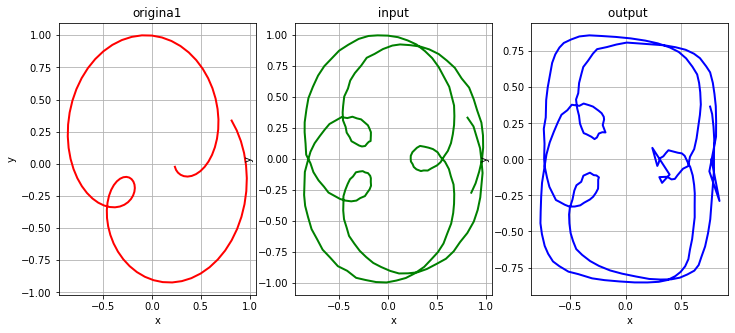

In [ ]:
plt.figure(figsize = figureSize)
plt.subplot(1,3,1)

# plt.scatter(y_test.reshape((20000,2))[:,0],y_test.reshape((20000,2))[:,1],linewidth=2,color='r')
plt.plot(y_resh [1, : , 0],y_resh[1 , :, 1],linewidth=2,color='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('origina1')
plt.grid()

plt.subplot(1,3,2)
# plt.scatter(x_test.reshape((20000,2))[:,0],y_hat.reshape((20000,2))[:,1],linewidth=2,color='g')
plt.plot(x_resh [1, : , 0], x_resh[1 , :, 1],linewidth=2,color='g')

plt.xlabel('x')
plt.ylabel('y')
plt.title(' input ')
plt.grid()


plt.subplot(1,3,3)
plt.plot(resh [1, : , 0], resh[1 , :, 1],linewidth=2,color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('output ')
plt.grid()

nephroid

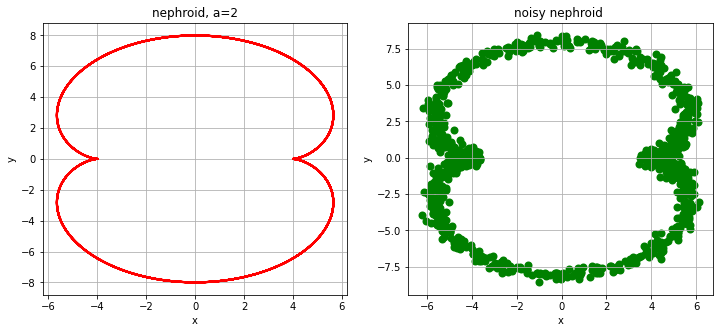

In [ ]:
a=2
x_nephroid = a*(np.cos(3*t)-3*np.cos(t))
y_nephroid = a*(np.sin(3*t)-3*np.sin(t))
x_nephroid_noisy , y_nephroid_noisy = make_noisy(x_nephroid) , make_noisy(y_nephroid)
plt.figure(figsize = figureSize)
plt.subplot(1,2,1)

plt.plot(x_nephroid,y_nephroid,linewidth=2,color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('nephroid, a=2')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(x_nephroid_noisy,y_nephroid_noisy,linewidth=2,color='g'  )
plt.xlabel('x')
plt.ylabel('y')
plt.title('noisy nephroid ')
plt.grid()

In [ ]:
noisy = np.zeros( (100, 1000  , 2))
denoised = np.zeros ( (100 , 1000  , 2))

for i in range(100):
  noisy[i,: ,0] , noisy[i , : , 1] = create_noise(x_nephroid) , create_noise(y_nephroid)
  denoised[i,: ,0] , denoised[i , : , 1] = x_nephroid ,y_nephroid


In [ ]:
maximum = denoised.max()
denoised = denoised / maximum
noisy = noisy / maximum

In [ ]:
samplingConst =1
y_train , y_validation , y_test = denoised[ :,  :700*samplingConst  ], denoised[ : ,  700*samplingConst:800*samplingConst ], denoised[:,  800*samplingConst: ] 
x_train , x_validation , x_test = noisy[ :,:700*samplingConst ]   , noisy[:, 700*samplingConst:800*samplingConst  ]  , noisy[ :, 800*samplingConst: ]

In [ ]:
y_train.shape , y_validation.shape , y_test.shape , x_train.shape , x_validation.shape , x_test.shape

((100, 700, 2),
 (100, 100, 2),
 (100, 200, 2),
 (100, 700, 2),
 (100, 100, 2),
 (100, 200, 2))

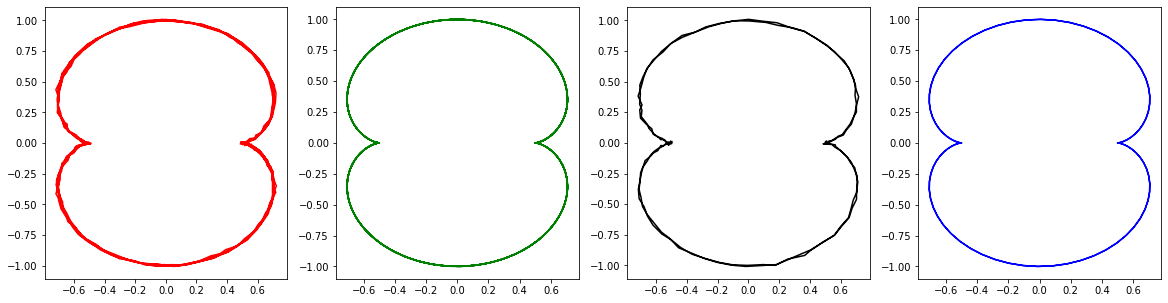

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,4,1)
plt.plot(x_train[1, : , 0], x_train[1,: , 1], color= 'r')
plt.subplot(1,4,2)
plt.plot(y_train[1, : , 0] , y_train[1, : , 1],color ='g')
plt.subplot(1,4,3)
plt.plot(x_test[1, : , 0], x_test[1, : , 1] , color= 'k')
plt.subplot(1,4,4)
plt.plot(y_test[1, : , 0], y_test[1, : , 1] , color= 'b')

In [ ]:
x_train = x_train.reshape((700,100,2))
x_validation = x_validation.reshape((100,100,2))
x_test = x_test.reshape((200,100,2))

y_train = y_train.reshape((700,100,2))
y_validation = y_validation.reshape((100,100,2))
y_test = y_test.reshape((200,100,2))

In [ ]:
y_train.shape , y_validation.shape , y_test.shape , x_train.shape , x_validation.shape , x_test.shape

((700, 100, 2),
 (100, 100, 2),
 (200, 100, 2),
 (700, 100, 2),
 (100, 100, 2),
 (200, 100, 2))

In [ ]:
y_train.shape , y_validation.shape , y_test.shape , x_train.shape , x_validation.shape , x_test.shape

((700, 100, 2),
 (100, 100, 2),
 (200, 100, 2),
 (700, 100, 2),
 (100, 100, 2),
 (200, 100, 2))

In [ ]:
model_input = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
model_output= tf.keras.layers.SimpleRNN(2, return_sequences=True)(model_input)
# model_output = tf.keras.layers.Dense(2 , activation = 'tanh') (m)
model = tf.keras.models.Model(inputs=model_input, outputs=model_output)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
# my_adam_optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(loss='mse', optimizer= my_adam_optimizer )
history=model.fit(x_train, y_train, epochs=30, validation_data=(x_validation, y_validation), batch_size=4, verbose=1)

Epoch 1/60
175/175 [==============================] - 5s 21ms/step - loss: 0.5951 - val_loss: 0.5018
Epoch 2/60
175/175 [==============================] - 4s 22ms/step - loss: 0.4260 - val_loss: 0.3614
Epoch 3/60
175/175 [==============================] - 5s 30ms/step - loss: 0.3174 - val_loss: 0.2792
Epoch 4/60
175/175 [==============================] - 3s 17ms/step - loss: 0.2506 - val_loss: 0.2242
Epoch 5/60
175/175 [==============================] - 3s 17ms/step - loss: 0.2025 - val_loss: 0.1816
Epoch 6/60
175/175 [==============================] - 3s 17ms/step - loss: 0.1635 - val_loss: 0.1457
Epoch 7/60
175/175 [==============================] - 3s 17ms/step - loss: 0.1299 - val_loss: 0.1143
Epoch 8/60
175/175 [==============================] - 3s 17ms/step - loss: 0.1006 - val_loss: 0.0875
Epoch 9/60
175/175 [==============================] - 3s 17ms/step - loss: 0.0769 - val_loss: 0.0671
Epoch 10/60
175/175 [==============================] - 3s 17ms/step - loss: 0.0595 - val_lo

In [ ]:
# Evaluation on the training
print('Evaluation with Test Set:')
loss = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
# Prediction
y_hat = model.predict(x_test)

Evaluation with Test Set:
7/7 [==============================] - 0s 11ms/step - loss: 0.0016
Test loss: 0.0015735182678326964


In [ ]:
x_test.shape

(200, 100, 2)

In [ ]:
y_hat.shape

(200, 100, 2)

In [ ]:
y_resh = y_test.reshape((200,100,2))
x_resh = x_test.reshape((100,200,2))
resh = y_hat.reshape((100,200 , 2))

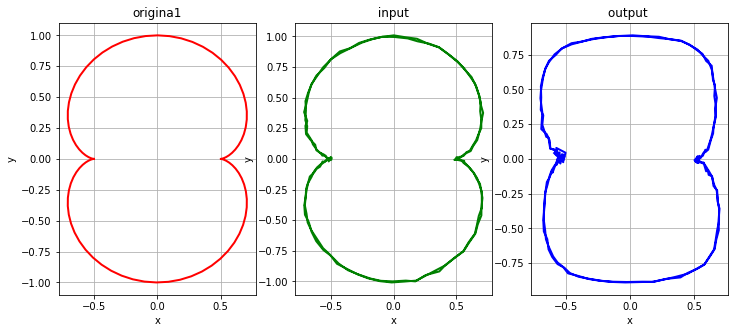

In [ ]:
plt.figure(figsize = figureSize)
plt.subplot(1,3,1)

plt.plot(y_resh [1, : , 0],y_resh[1 , :, 1],linewidth=2,color='r')
# plt.scatter(y_resh [1, : , 0],y_resh[1 , :, 1],linewidth=2,color='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('origina1')
plt.grid()

plt.subplot(1,3,2)
plt.plot(x_resh [1, : , 0], x_resh[1 , :, 1],linewidth=2,color='g')
# plt.scatter(x_resh [1, : , 0], x_resh[1 , :, 1],linewidth=2,color='g')

plt.xlabel('x')
plt.ylabel('y')
plt.title(' input ')
plt.grid()


plt.subplot(1,3,3)
plt.plot(resh [1, : , 0], resh[1 , :, 1],linewidth=2,color='b')
# plt.scatter(resh [1, : , 0], resh[1 , :, 1],linewidth=2,color='b')

plt.xlabel('x')
plt.ylabel('y')
plt.title('output ')
plt.grid()

## AUDIO

In [60]:
signal_file = '/content/drive/MyDrive/audio/data_signal.wav'
signal_, sr = librosa.load(signal_file)
signal=np.interp(signal_, (signal_.min(), signal_.max()), (-1, 1))

In [78]:
dur  = np.ceil(len(signal)/sr)       

In [79]:
dur

3.0

In [80]:
len(signal)

58176

In [71]:
sr

22050

In [74]:
length = len(signal) / sr

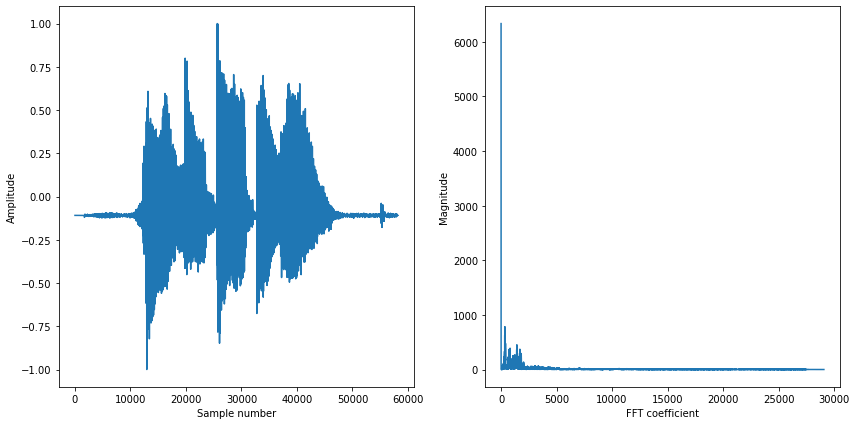

In [85]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(signal )
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.subplot(1,2,2)
X=np.fft.rfft(signal)
radius,angle=to_polar(X)
plt.plot(radius)
plt.xlabel("FFT coefficient")
plt.ylabel("Magnitude")
plt.show()

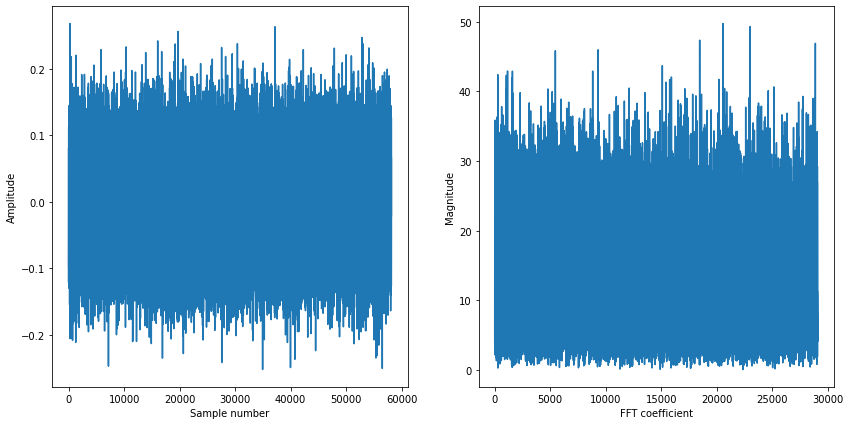

In [62]:
noise=get_white_noise(signal,SNR=10)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(noise)
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.subplot(1,2,2)
X=np.fft.rfft(noise)
radius,angle=to_polar(X)
plt.plot(radius)
plt.xlabel("FFT coefficient")
plt.ylabel("Magnitude")
plt.show()

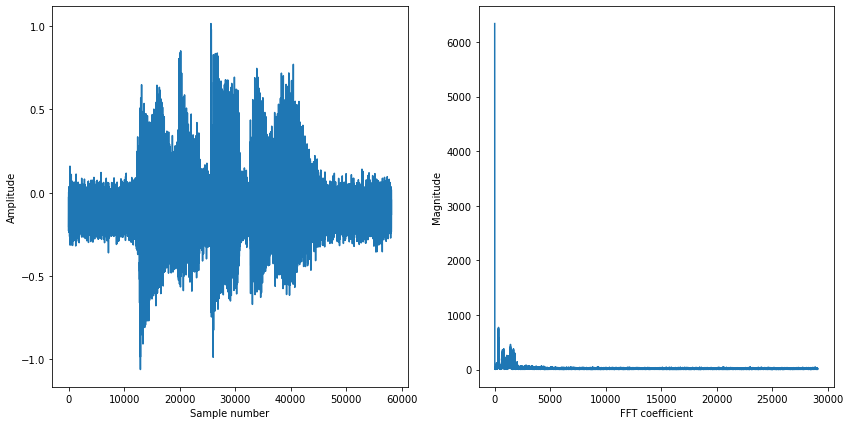

In [63]:
signal_noise=signal+noise
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(signal_noise)
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.subplot(1,2,2)
X=np.fft.rfft(signal_noise)
radius,angle=to_polar(X)
plt.plot(radius)
plt.xlabel("FFT coefficient")
plt.ylabel("Magnitude")
plt.show()

In [91]:
calc_SNR(signal, signal_noise)

10.383892994642551

In [92]:
signal.shape[0],

(58176,)

In [116]:
signal = np.array(signal).T
signal_noise= np.array(signal_noise).T
#تصمیم گرفتم داده ها رو با تعدادی کم تر از نرخ سمپلینگ تقسیم کنم که تو هر تیکه یه جور نویز باقی بمونه

input_data  = np.zeros((11, 2000,1)) # (30, 22050,1)
output_data = np.zeros((11, 2000,1)) # (30, 22050,1)

In [118]:
for i in range(11):
  i_st = 2000*i
  i_ed = 2000*(i+1)
  input_data[i,: ,0] = signal_noise[i_st : i_ed]
  output_data[i,: , 0] = signal[i_st : i_ed]

In [119]:
output_data.shape

(11, 2000, 1)

In [122]:

# train on 20 seconds
x_train = input_data [:8, :]
y_train = output_data[:8, :]


# 1 periods for validation data
# train on 1  seconds
x_validation = input_data [8:9, :]
y_validation = output_data[8:9, :]

# test data is the rest of data 
x_test = input_data [9:, :]
y_test = output_data[9:, :]


print('x_train, y_train', x_train.shape, y_train.shape)
print('x_valid, y_valid', x_validation.shape, y_validation.shape)
print('x_test, y_test', x_test.shape, y_test.shape)

x_train, y_train (8, 2000, 1) (8, 2000, 1)
x_valid, y_valid (1, 2000, 1) (1, 2000, 1)
x_test, y_test (2, 2000, 1) (2, 2000, 1)


In [124]:
# SimpleRNN
SimpleRNNmodel=tf.keras.models.Sequential()
SimpleRNNmodel.add(tf.keras.layers.SimpleRNN(30, input_shape = (2000,1) ,  activation='tanh' ))
SimpleRNNmodel.add(tf.keras.layers.Dense(2000, activation='tanh'))
SimpleRNNmodel.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
history1 = SimpleRNNmodel.fit(x_train, y_train, epochs=6, batch_size= 1, validation_data= (x_validation , y_validation),  verbose=1)

Epoch 1/6
8/8 [==============================] - 4s 258ms/step - loss: 0.0304 - val_loss: 0.0730
Epoch 2/6
8/8 [==============================] - 2s 225ms/step - loss: 0.0265 - val_loss: 0.0688
Epoch 3/6
8/8 [==============================] - 2s 222ms/step - loss: 0.0223 - val_loss: 0.0638
Epoch 4/6
8/8 [==============================] - 2s 221ms/step - loss: 0.0186 - val_loss: 0.0630
Epoch 5/6
8/8 [==============================] - 2s 320ms/step - loss: 0.0165 - val_loss: 0.0632
Epoch 6/6
8/8 [==============================] - 6s 740ms/step - loss: 0.0146 - val_loss: 0.0631


Text(0.5, 1.0, 'LSTM, Loss History')

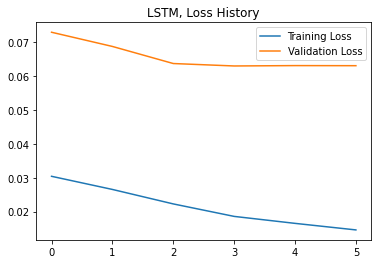

In [126]:
fig = plt.figure()
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM, Loss History')

In [125]:
# LSTM
model_LSTM=tf.keras.models.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(30, input_shape = (2000,1) ,  activation='tanh' ))
model_LSTM.add(tf.keras.layers.Dense(2000, activation='tanh'))
model_LSTM.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
history2 = model_LSTM.fit(x_train, y_train, epochs=30, batch_size= 1, validation_data= (x_validation , y_validation),  verbose=1)


Epoch 1/30
8/8 [==============================] - 5s 471ms/step - loss: 0.0299 - val_loss: 0.0736
Epoch 2/30
8/8 [==============================] - 3s 382ms/step - loss: 0.0279 - val_loss: 0.0711
Epoch 3/30
8/8 [==============================] - 3s 399ms/step - loss: 0.0253 - val_loss: 0.0667
Epoch 4/30
8/8 [==============================] - 3s 411ms/step - loss: 0.0213 - val_loss: 0.0642
Epoch 5/30
8/8 [==============================] - 3s 401ms/step - loss: 0.0190 - val_loss: 0.0595
Epoch 6/30
8/8 [==============================] - 3s 396ms/step - loss: 0.0177 - val_loss: 0.0602
Epoch 7/30
8/8 [==============================] - 3s 401ms/step - loss: 0.0170 - val_loss: 0.0605
Epoch 8/30
8/8 [==============================] - 3s 405ms/step - loss: 0.0169 - val_loss: 0.0616
Epoch 9/30
8/8 [==============================] - 3s 425ms/step - loss: 0.0169 - val_loss: 0.0617
Epoch 10/30
8/8 [==============================] - 3s 410ms/step - loss: 0.0166 - val_loss: 0.0627
Epoch 11/30
8/8 [==

In [ ]:
plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , noisyInput , 'g' )
plt.title('input')
plt.grid()

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , reshaped_generated_output , 'b' )
plt.title('generated output')
plt.grid()

plt.figure(figsize = figSize)
plt.plot (timePoints[:200*samplingConst] , desiredDenoisedOutput , 'r')
plt.title('target')
plt.grid()


Text(0.5, 1.0, 'LSTM, Loss History')

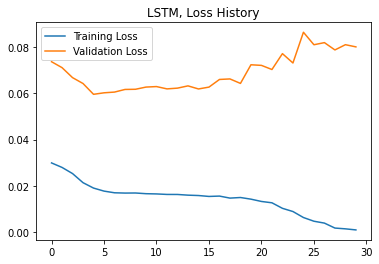

In [127]:
#15 epochs are enough
fig = plt.figure()
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM, Loss History')

In [ ]:
generated_output = model_LSTM.predict(x_test)
reshaped_generated_output = generated_output.reshape( (200*samplingConst,1))
noisyInput = x_test.reshape( (200*samplingConst,1))
desiredDenoisedOutput = y_test.reshape(200*samplingConst,1)

In [ ]:
SNR_BEFORE_SINE_RNN = calc_SNR( desiredDenoisedOutput , noisyInput )
SNR_AFTER_SINE_RNN = calc_SNR( desiredDenoisedOutput , reshaped_generated_output )

In [ ]:

#crop noise if its longer than signal
#for this code len(noise) shold be greater than len(signal)
#it will not work otherwise!
if(len(noise)>len(signal)):
    noise=noise[0:len(signal)]

noise=get_noise_from_sound(signal,noise,SNR=10)

signal_noise=signal+noise


print("SNR = " + str(20*np.log10(math.sqrt(np.mean(signal**2))/math.sqrt(np.mean(noise**2)))))

plt.plot(signal_noise)
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.show()

from scipy.io.wavfile import write
write("/home/sleek_eagle/research/emotion/code/audio_processing/bbb.wav",sr,signal_noise)


